In [79]:
import torch
import torch.nn as nn
import torchaudio
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import ASTModel
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast, GradScaler
from tqdm import tqdm
from transformers import ASTModel, AutoModel
import json, os
from pathlib import Path
from torchvision import models
import numpy as np
import cv2
import torchaudio.transforms as T
from torchvision import transforms

In [19]:
class AudioDataset(Dataset):
    def __init__(self, metadata, augment=False):
        self.meta = metadata
        self.augment = augment

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        item = self.meta[idx]
        mel = torch.load(item["mel"]).float()   # [128, T]
        label = torch.tensor(item["highlight"], dtype=torch.float32)
        return mel, label

In [29]:
def wav_to_melspectrogram_jpg(wav_path, jpg_path, sr=22050, n_mels=128, n_fft=2048, hop_length=512):
    try:
        # Load audio
        waveform, sample_rate = torchaudio.load(wav_path)

        # Resample if needed
        if sample_rate != sr:
            waveform = T.Resample(sample_rate, sr)(waveform)

        # Convert to mono
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # Mel transform
        mel_spec = T.MelSpectrogram(
            sample_rate=sr,
            n_mels=n_mels,
            n_fft=n_fft,
            hop_length=hop_length,
            power=2.0
        )(waveform)

        # Convert to log scale
        mel_db = T.AmplitudeToDB(top_db=80)(mel_spec)[0]  # [mel, time]

        # Normalize to [0, 255]
        mel = mel_db.numpy()
        mel_norm = (mel - mel.min()) / (mel.max() - mel.min() + 1e-6)
        mel_img = (mel_norm * 255).astype(np.uint8)

        # Save as grayscale JPG
        cv2.imwrite(jpg_path, mel_img)

        return True

    except Exception as e:
        print(f"Error converting {wav_path}: {e}")
        return False

In [34]:
# Batch convert all WAV files to mel-spectrograms for all splits
print("=" * 60)
print("Converting all WAV files to mel-spectrograms...")
print("=" * 60)

base_path = Path(os.getcwd()).joinpath("data")
output_path = base_path / "data"
for split in ["train", "val", "test"]:
    clips_file = output_path / split / "clips.json"
    
    if clips_file.exists():
        print(f"\nProcessing {split} split...")
        
        # Load clips
        with open(clips_file, 'r') as f:
            clips = json.load(f)
        
        # Create audio_img directory if it doesn't exist
        audio_img_dir = output_path / split / "audio_img"
        audio_img_dir.mkdir(parents=True, exist_ok=True)
        
        converted_count = 0
        failed_count = 0
        
        # Convert each audio file
        for i, clip in enumerate(clips):
            if clip.get("audio"):
                # Get the audio filename
                audio_filename = clip["audio"].split("/")[-1]
                audio_path = output_path / split / "audio" / audio_filename
                
                # Create spectrogram path
                spectrogram_filename = audio_filename.replace(".wav", ".jpg")
                spectrogram_path = audio_img_dir / spectrogram_filename
                
                # Convert to spectrogram
                if audio_path.exists():
                    success = wav_to_melspectrogram_jpg(str(audio_path), str(spectrogram_path))
                    if success:
                        # Add audio_img field to clip
                        clip["audio_img"] = f"data/data/{split}/audio_img/{spectrogram_filename}"
                        converted_count += 1
                        if (i + 1) % 50 == 0:
                            print(f"  Converted {i + 1}/{len(clips)} clips...")
                    else:
                        failed_count += 1
                else:
                    print(f"  Audio file not found: {audio_path}")
                    failed_count += 1
        
        # Write updated clips.json
        with open(clips_file, 'w') as f:
            json.dump(clips, f, indent=2)
        
        print(f"  ✓ {split}: {converted_count} converted, {failed_count} failed")

print("\n" + "=" * 60)
print("✓ Spectrogram conversion complete!")
print("=" * 60)


Converting all WAV files to mel-spectrograms...

Processing train split...
  Converted 50/3111 clips...
  Converted 100/3111 clips...
  Converted 150/3111 clips...
  Converted 200/3111 clips...
  Converted 250/3111 clips...
  Converted 300/3111 clips...
  Converted 350/3111 clips...
  Converted 400/3111 clips...
  Converted 450/3111 clips...
  Converted 500/3111 clips...
  Converted 550/3111 clips...
  Converted 600/3111 clips...
  Converted 650/3111 clips...
  Converted 700/3111 clips...
  Converted 750/3111 clips...
  Converted 800/3111 clips...
  Converted 850/3111 clips...
  Converted 900/3111 clips...
  Converted 950/3111 clips...
  Converted 1000/3111 clips...
  Converted 1050/3111 clips...
  Converted 1100/3111 clips...
  Converted 1150/3111 clips...
  Converted 1200/3111 clips...
  Converted 1250/3111 clips...
  Converted 1300/3111 clips...
  Converted 1350/3111 clips...
  Converted 1400/3111 clips...
  Converted 1450/3111 clips...
  Converted 1500/3111 clips...
  Converted 155

In [35]:

# Verify spectrogram conversion and updated clips.json
print("=" * 60)
print("VERIFICATION: Spectrogram Conversion Complete")
print("=" * 60)

for split in ["train", "val", "test"]:
    audio_img_dir = output_path / split / "audio_img"
    jpg_files = list(audio_img_dir.glob("*.jpg")) if audio_img_dir.exists() else []
    
    clips_file = output_path / split / "clips.json"
    with open(clips_file, 'r') as f:
        clips = json.load(f)
    
    clips_with_audio_img = sum(1 for clip in clips if "audio_img" in clip)
    
    print(f"\n{split.upper()}:")
    print(f"  JPG files created: {len(jpg_files)}")
    print(f"  Clips with audio_img field: {clips_with_audio_img}/{len(clips)}")

print("\n" + "-" * 60)
print("Sample clip (first clip of train split):")
print("-" * 60)

with open(output_path / "train" / "clips.json", 'r') as f:
    clips = json.load(f)
    if clips:
        sample_clip = clips[0]
        print(json.dumps(sample_clip, indent=2))


VERIFICATION: Spectrogram Conversion Complete

TRAIN:
  JPG files created: 3111
  Clips with audio_img field: 3111/3111

VAL:
  JPG files created: 664
  Clips with audio_img field: 664/664

TEST:
  JPG files created: 777
  Clips with audio_img field: 777/777

------------------------------------------------------------
Sample clip (first clip of train split):
------------------------------------------------------------
{
  "game_id": "20160305_1800_Manchester_City_4_0_Aston_Villa",
  "original_game_name": "2016-03-05 - 18-00 Manchester City 4 - 0 Aston Villa",
  "clip_name": "20160305_1800_Manchester_City_4_0_Aston_Villa_half2_clip_0345",
  "half": 2,
  "start_ms": 8000,
  "end_ms": 16000,
  "highlight": 0,
  "video": "data/data/train/video/20160305_1800_Manchester_City_4_0_Aston_Villa_half2_clip_0345.mkv",
  "audio": "data/data/train/audio/20160305_1800_Manchester_City_4_0_Aston_Villa_half2_clip_0345.wav",
  "text": "data/data/train/text/20160305_1800_Manchester_City_4_0_Aston_Villa_h

In [61]:
class AudioMelDataset(Dataset):
    def __init__(self, split_dir, transform=None):
        self.split_dir = split_dir
        self.transform = transform

        with open(os.path.join(split_dir, "clips.json"), "r") as f:
            self.clips = json.load(f)

    def __len__(self):
        return len(self.clips)

    def __getitem__(self, idx):
        clip = self.clips[idx]
        img_path = clip["audio_img"]   # path already stored in JSON

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Failed to load: {img_path}")
            
        img = self.transform(img)

        label = torch.tensor(clip["highlight"], dtype=torch.float32)
        return img, label


In [62]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [63]:
train_set = AudioMelDataset("data/data/train", transform=train_transform)
val_set   = AudioMelDataset("data/data/val",   transform=test_transform)
test_set  = AudioMelDataset("data/data/test",  transform=test_transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_set,   batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_set,  batch_size=32, shuffle=False, num_workers=0)

print(len(train_set), len(val_set), len(test_set))


3111 664 777


In [ ]:
class AudioResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Modify first convolution: 3 channels → 1 channel
        old_weight = self.model.conv1.weight.clone()

        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Average across RGB channels to initialize weights
        self.model.conv1.weight.data = old_weight.mean(dim=1, keepdim=True)

        # Replace FC for binary classification
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze(1)

        


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 6
model = AudioResNet18().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [98]:
os.makedirs("audio_checkpoints", exist_ok=True)

history = {
    "train_loss": [],
    "train_acc": [],
  
    "val_loss": [],
    "val_acc": [],
}

best_val_acc = 0.0
for epoch in range(EPOCHS):
    # =================================================
    # TRAINING
    # =================================================
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training", leave=True)
    for mel, label in pbar:
        mel, label = mel.to(device), label.to(device)

        optimizer.zero_grad()
        logits = model(mel)
        loss = criterion(logits, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * mel.size(0)

        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds.cpu() == label.cpu()).sum().item()
        total += label.size(0)

        pbar.set_postfix({"loss": loss.item()})

    train_loss /= len(train_loader.dataset)
    train_acc = correct / total

    # =================================================
    # VALIDATION
    # =================================================
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validating", leave=True)
    with torch.no_grad():
        for mel, label in pbar:
            mel, label = mel.to(device), label.to(device)

            logits = model(mel)
            loss = criterion(logits, label)

            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds.cpu() == label.cpu()).sum().item()
            val_total += label.size(0)

            val_loss += loss.item() * mel.size(0)
            pbar.set_postfix({"loss": loss.item()})

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / val_total

    # =================================================
    # SCHEDULER STEP
    # =================================================
    scheduler.step()

    # =================================================
    # STORE HISTORY
    # =================================================
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # =================================================
    # PRINT EPOCH SUMMARY
    # =================================================
    print(f"\nEpoch {epoch+1}/{EPOCHS} Results:")
    print(f"Train Loss: {train_loss:.4f}  |  Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f}  |  Val Acc:   {val_acc:.4f}")
    print(f"LR Now: {optimizer.param_groups[0]['lr']:.6f}")

    # =================================================
    # SAVE CHECKPOINTS
    # =================================================
    checkpoint = {
        "epoch": epoch + 1,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),

        "train_loss": train_loss,
        "train_acc": train_acc,

        "val_loss": val_loss,
        "val_acc": val_acc,
    }

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(checkpoint, "audio_checkpoints/audio_model.pt")
        print("🔥 New best model saved!")

print("\nTraining complete!")


Epoch 1/6 - Validating: 100%|██████████| 21/21 [00:01<00:00, 20.57it/s, loss=0.547]



Epoch 1/6 Results:
Train Loss: 0.4347  |  Train Acc: 0.8197
Val Loss:   0.4813  |  Val Acc:   0.7651
LR Now: 0.000056
🔥 New best model saved!


Epoch 2/6 - Validating: 100%|██████████| 21/21 [00:01<00:00, 20.49it/s, loss=0.466]



Epoch 2/6 Results:
Train Loss: 0.3359  |  Train Acc: 0.8682
Val Loss:   0.4651  |  Val Acc:   0.7982
LR Now: 0.000045
🔥 New best model saved!


Epoch 3/6 - Validating: 100%|██████████| 21/21 [00:01<00:00, 20.67it/s, loss=0.488]



Epoch 3/6 Results:
Train Loss: 0.2387  |  Train Acc: 0.9113
Val Loss:   0.5081  |  Val Acc:   0.7801
LR Now: 0.000030


Epoch 4/6 - Validating: 100%|██████████| 21/21 [00:01<00:00, 20.61it/s, loss=0.648]



Epoch 4/6 Results:
Train Loss: 0.1521  |  Train Acc: 0.9531
Val Loss:   0.8070  |  Val Acc:   0.7952
LR Now: 0.000015


Epoch 5/6 - Validating: 100%|██████████| 21/21 [00:01<00:00, 19.53it/s, loss=0.498]



Epoch 5/6 Results:
Train Loss: 0.0966  |  Train Acc: 0.9727
Val Loss:   0.5391  |  Val Acc:   0.7771
LR Now: 0.000004


Epoch 6/6 - Validating: 100%|██████████| 21/21 [00:01<00:00, 19.92it/s, loss=0.482]


Epoch 6/6 Results:
Train Loss: 0.0683  |  Train Acc: 0.9826
Val Loss:   0.5513  |  Val Acc:   0.7877
LR Now: 0.000000

Training complete!


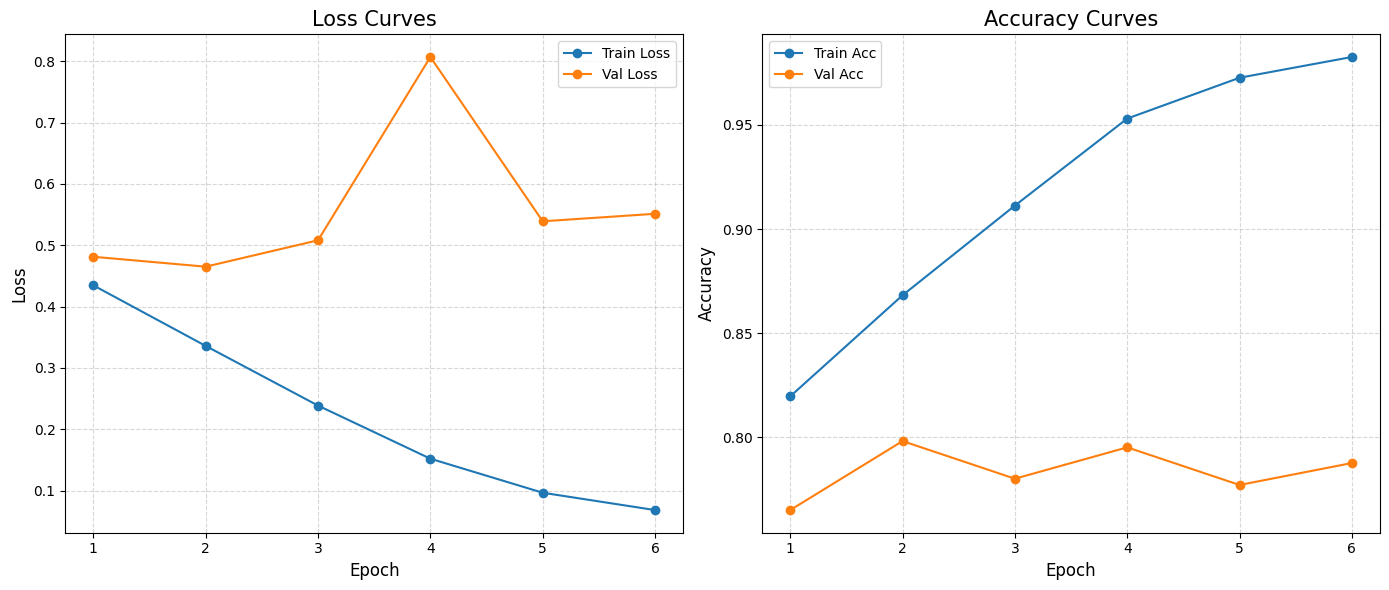

In [99]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(14, 6))

# ==========================
# LOSS
# ==========================
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
plt.plot(epochs, history["val_loss"], label="Val Loss", marker="o")
plt.title("Loss Curves", fontsize=15)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

# ==========================
# ACCURACY
# ==========================
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Acc", marker="o")
plt.plot(epochs, history["val_acc"], label="Val Acc", marker="o")
plt.title("Accuracy Curves", fontsize=15)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()


In [100]:
@torch.no_grad()
def eval_on_test(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(test_loader, desc="Testing", leave=True)

    for mel, label in pbar:
        mel, label = mel.to(device), label.to(device)

        logits = model(mel)
        loss = criterion(logits, label)

        preds = (torch.sigmoid(logits) > 0.5).float()

        correct += (preds.cpu() == label.cpu()).sum().item()
        total += label.size(0)
        total_loss += loss.item() * mel.size(0)

        pbar.set_postfix({"loss": loss.item()})

    test_loss = total_loss / len(test_loader.dataset)
    test_acc = correct / total

    return test_loss, test_acc


In [102]:
# Load best model checkpoint
checkpoint = torch.load("audio_checkpoints/audio_model.pt", map_location=device)

model.load_state_dict(checkpoint["model_state"])
scheduler.load_state_dict(checkpoint["scheduler_state"])  # Optional

print("Loaded best model!")

test_loss, test_acc = eval_on_test(model, test_loader, criterion, device)

print("\n===== TEST RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc:  {test_acc:.4f}")


Loaded best model!


Testing: 100%|██████████| 25/25 [00:01<00:00, 17.24it/s, loss=0.365]


===== TEST RESULTS =====
Test Loss: 0.4350
Test Acc:  0.8546
